In [28]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [29]:
! pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

df = pd.read_csv("My Drive/10X/Week2/AdSmartABdata.csv")
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [31]:
df.dtypes

auction_id     object
experiment     object
date           object
hour            int64
device_make    object
platform_os     int64
browser        object
yes             int64
no              int64
dtype: object

In [32]:
df.shape

(8077, 9)

In [33]:
df_control = df[df['experiment'] == 'control']
n_con = df_control.shape[0]
print('number of total users that are exposed to the control ads are ' + str(n_con))

number of total users that are exposed to the control ads are 4071


In [34]:
df_control_yes = df_control[df_control['yes'] == 1]
x_con = df_control_yes.shape[0]
print('number of converted users that are exposed to the control ads are ' + str(x_con))

number of converted users that are exposed to the control ads are 264


In [35]:
df_exposed = df[df['experiment'] == 'exposed']
n_exp = df_exposed.shape[0]
print('number of total users that are exposed to the smart ads are ' + str(n_exp))

number of total users that are exposed to the smart ads are 4006


In [36]:
df_exposed_yes = df_exposed[df_exposed['yes'] == 1]
x_exp = df_exposed_yes.shape[0]
print('number of converted users that are exposed to the smart ads are ' + str(x_exp))

number of converted users that are exposed to the smart ads are 308


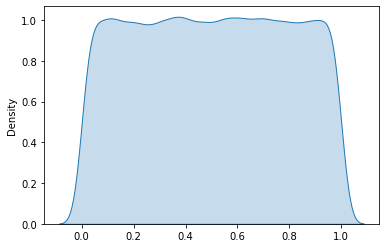

In [37]:
# Generate prior draws
prior_draws = np.random.beta(1, 1, 100000)

# Plot the prior
sns.kdeplot(prior_draws, shade=True, label="prior")
plt.show()

In [38]:
# Extract the yes column for each group
yes_exp = df_exposed["yes"]
yes_con = df_control["yes"]

### Simulate beta posterior
We know that if the prior is Beta(a,b), then the posterior is Beta(x,y), with: 

x = Number Of Successes + a 

y = Number Of Observations − Number Of Successes + b

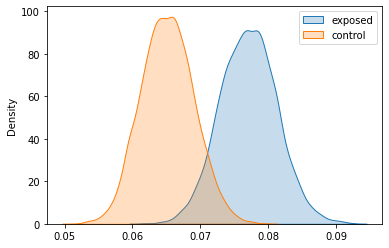

In [39]:
def simulate_beta_posterior(trials, beta_prior_a, beta_prior_b):    
  num_successes = np.sum(trials)    
  posterior_draws = np.random.beta(      
      num_successes + beta_prior_a,       
      len(trials) - num_successes + beta_prior_b, 10000    
      )
  return posterior_draws

# Simulate posterior draws for each product
exp_posterior = simulate_beta_posterior(yes_exp, 1, 1)
con_posterior = simulate_beta_posterior(yes_con, 1, 1)

sns.kdeplot(exp_posterior, shade=True)
sns.kdeplot(con_posterior, shade=True)
plt.legend(labels=["exposed","control"])
plt.show()

Judging from the plot we are more certain about the retention rate estimate of the control ads than for the smart ads because the posterior distribution for the control group is higher, indicating less uncertainty. Also, it is more probable that smart ads are better but we are not completely sure about it, since the two posteriors overlap. To find out, we will have to calculate the posterior difference between control and experiment retention rates.

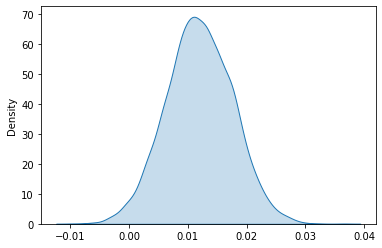

In [40]:
# Calculate posterior difference and plot it
diff = exp_posterior - con_posterior
sns.kdeplot(diff, shade=True, label="diff")
plt.show()

Take a look at the posterior density plot of the difference in click rates: it is very likely positive, indicating that smart ads are likely better. Let's calculate a credible interval for the difference to measure the uncertainty in the estimate.

In [41]:
# Calculate and print 90% credible interval of posterior difference
interval = pm.hdi(diff, hdi_prob=0.9)
print(interval)

[0.00265358 0.02117034]


The credible interaval indicates that with 90% probability, the smart ads click rate is up to 2.1 percentage points higher than the one for control. Finally, let's calculate the percentage of cases where this difference is positive, which corresponds to exposed retention rate being higher.

In [42]:
# Calculate and print probability of smart ad being better
smart_better_prob = (diff > 0).mean()
print(smart_better_prob)

0.9811


Finally, the probability that the clothes click rate is higher is 98%. But there is an approximately 3% chance that actually control ads are better. How great is that risk? How many clicks do we lose if we roll out the smart ads campaign? 

The answer to this is the expected loss: the average posterior difference between the two retention ratios given that control ads do better. To calculate it, we only need to take the entries in the posterior difference where the control retention rate is higher and compute their average.

In [43]:
# Slice diff to take only cases where it is negative
loss = diff[diff < 0]

# Compute and print expected loss
expected_loss = np.mean(loss)
print(expected_loss)

-0.0019032669112987106


This looks good. We can sefely roll out the smart ads campaign to a larger audience because we are 98% sure it has a higher retention rate, and even if the 3% risk of this being a wrong decision materializes, we will only lose 0.2 percentage points in the retention rate, which is a very small risk.